In [1]:
import numpy as np
import pylab as plt
import hydra

In [2]:
times = np.linspace(0., 1., 16)
freqs = np.linspace(100., 120., 16)

class args():
    def __init__(self):
        self.beam_sim_type = 'gaussian'
        self.hex_array = (2,3)

dec = np.deg2rad(-30.7 * np.ones(20))
ra = np.linspace(0., 2.*np.pi, dec.size)
        
model0_chunk, fluxes_chunk, beams, ant_info \
    = hydra.example.run_example_simulation(
                                     args=args(), 
                                     times=times, 
                                     freqs=freqs, 
                                     output_dir=None, 
                                     ra=ra, 
                                     dec=dec, 
                                     ptsrc_amps=np.ones(dec.size), 
                                     array_latitude=np.deg2rad(-30.7215),
                                     verbose=False)
ants, ant_pos, antpairs, ants1, ants2 = ant_info
Nants = len(ants)

beam type: gaussian
(0) Simulation 0.1622018814086914


In [3]:
# Construct partial Fourier basis with only low-order modes, evaluated on 
# the time/freq. ranges belonging to this worker
# NOTE: If you do freq.max() - freq.min(), this will not be periodic!
Lfreq = (freqs[1] - freqs[0]) * freqs.size
Ltime = (times[1] - times[0]) * times.size
Fbasis, k_freq, k_time = hydra.utils.partial_fourier_basis_2d_from_nmax(
                                            freqs=freqs, 
                                            times=times, 
                                            nmaxfreq=1, 
                                            nmaxtime=1, 
                                            Lfreq=Lfreq, 
                                            Ltime=Ltime)
Ngain_modes = k_freq.size
Nants = len(ants)

# Define gains and gain perturbations
gains_chunk = (1. + 0.j) * np.ones((Nants, freqs.size, times.size), 
                                   dtype=model0_chunk.dtype)

# Gain perturbations
delta_g_amps = np.zeros((Nants, Ngain_modes), dtype=gains_chunk.dtype)
delta_g_amps[0, 0] = 0.2 # Only one perturbation to one antenna
delta_g_amps[1, 0] = 0.1 # Only one perturbation to one antenna
delta_g_chunk = np.tensordot(delta_g_amps, Fbasis, axes=((1,), (0,)))

# Apply gains to model
data_chunk = model0_chunk.copy()
hydra.apply_gains(data_chunk, 
                  gains_chunk * (1. + delta_g_chunk), 
                  ants, 
                  antpairs, 
                  inline=True)

# Add noise
sigma_noise = 0.001
noise_chunk = sigma_noise * np.sqrt(0.5) \
                          * (  1.0 * np.random.randn(*data_chunk.shape) \
                             + 1.j * np.random.randn(*data_chunk.shape))
data_chunk += noise_chunk

noise_var_chunk = (sigma_noise)**2. * np.ones(data_chunk.shape)
inv_noise_var_chunk = 1. / noise_var_chunk

# Current data model is just the true visibility model
current_data_model_chunk = model0_chunk.copy() \
                         + sigma_noise*np.random.randn(*model0_chunk.shape)

GAINS (21, 16, 16) (7, 16, 16) [0 1 2 3 4 5 6]


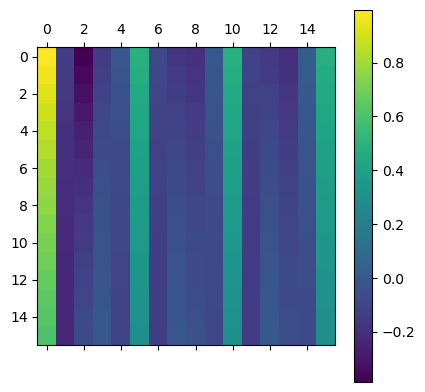

In [4]:
plt.matshow(model0_chunk[0].real)
plt.colorbar()

#plt.matshow(current_data_model_chunk[0].real)

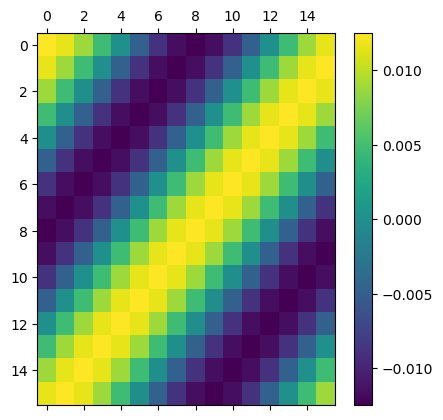

In [5]:
plt.matshow(delta_g_chunk[0].real, aspect='auto')
plt.colorbar()

In [6]:
# Current_data_model DOES NOT include gbar_i gbar_j^* factor, so we need
# to apply it here to calculate the residual
ggv_chunk = hydra.apply_gains(current_data_model_chunk,
                              gains_chunk,
                              ants,
                              antpairs,
                              inline=False)
resid_chunk = data_chunk - ggv_chunk

# Shape of the gain solution vector
x_shape = 2*len(ants)*Fbasis.shape[0]

gain_pspec_sqrt = 1.*np.ones(Fbasis.shape[0])

GAINS (21, 16, 16) (7, 16, 16) [0 1 2 3 4 5 6]


In [7]:
A_real.shape

NameError: name 'A_real' is not defined

In [8]:
def construct_rhs(
    resid, inv_noise_var, pspec_sqrt, A_real, A_imag, model_vis, Fbasis, realisation=True
):
    # fft: data -> fourier
    # ifft: fourier -> data
    Nvis, Ntimes, Nfreqs = resid.shape
    Nmodes = Fbasis.shape[0]
    Nants = A_real.shape[-1]
    Nfrate = Ntimes
    Ntau = Nfreqs

    # Switch to turn random realisations on or off
    realisation_switch = 1.0 if realisation else 0.0

    # (Term 2): \omega_y
    b = (
        realisation_switch
        * (
            1.0 * np.random.randn(Nants, Nmodes)
            + 1.0j * np.random.randn(Nants, Nmodes)
        )
        / np.sqrt(2.0)
    )

    # (Terms 1+3): S^1/2 F^dagger A^\dagger [ N^{-1} r + N^{-1/2} \omega_r ]
    omega_r = (
        realisation_switch
        * (1.0 * np.random.randn(*resid.shape) + 1.0j * np.random.randn(*resid.shape))
        / np.sqrt(2.0)
    )
    gain_shape = (Nants, Nfreqs, Ntimes)

    # Apply inverse noise (or its sqrt) to data/random vector terms, and do
    # transpose projection operation, all in real space
    yy = hydra.gain_sampler.apply_proj_conj(
        resid * inv_noise_var + omega_r * np.sqrt(inv_noise_var),
        A_real,
        A_imag,
        model_vis,
        gain_shape,
    )
    
    # Conjugate basis
    FFc = Fbasis.conj().reshape((Fbasis.shape[0], -1))
    
    # Do FT to go into Fourier space again
    _y = np.zeros_like(b)
    for k in range(Nants):
        #yy[k,:,:] = fft.fft2(yy[k,:,:])
        _y[k,:] = np.tensordot(FFc, yy[k, :, :].flatten(), axes=((1,), (0,)))

    # Apply sqrt(S) operator
    # FIXME
    #yy = apply_sqrt_pspec(pspec_sqrt, yy)

    # Add the transformed Terms 1+3 to b vector
    return b + _y


7 21
(21, 16, 16) (21, 7) (21, 16, 16)
b = (56,) (4, 16, 16) 28 56


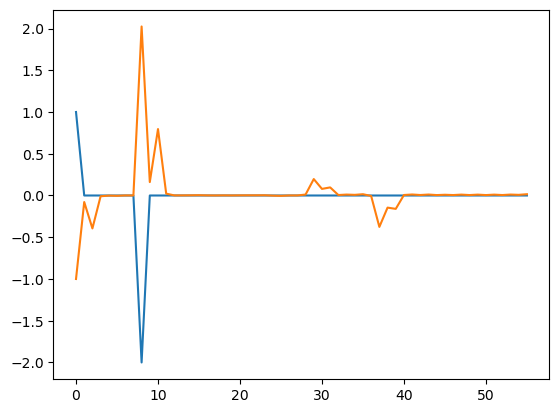

In [9]:
def apply_operator(x, inv_noise_var, pspec_sqrt, A_real, A_imag, model_vis, Fbasis):
    assert inv_noise_var.shape == model_vis.shape
    
    # Reshape input vector
    Nmodes, Nfreqs, Ntimes = Fbasis.shape
    vec = x.reshape((-1, 2*Nmodes))
    Nants = vec.shape[0]
    
    # Extract real and imaginary parts, reshape, and multiply by sqrt of prior var
    xre = pspec_sqrt[np.newaxis,:] * x[:x.size//2].reshape((Nants, Nmodes))
    xim = pspec_sqrt[np.newaxis,:] * x[x.size//2:].reshape((Nants, Nmodes))
    
    # Conjugate basis
    FFc = Fbasis.conj().reshape((Fbasis.shape[0], -1))
    
    # Multiply Fourier x values by S^1/2 and FT
    #sqrtSx = vec #hydra.gain_sampler.apply_sqrt_pspec(pspec_sqrt, x) # x has shape (Nants, )
    sqrtSx = np.zeros((vec.shape[0], Fbasis.shape[1], Fbasis.shape[2]), dtype=np.complex128)
    for k in range(sqrtSx.shape[0]):
        ##sqrtSx[k, :, :] = fft.ifft2(sqrtSx[k, :, :])
        sqrtSx[k, :, :] = np.tensordot(Fbasis, xre[k, :] + 1.j*xim[k, :], axes=((0,), (0,)))
    gain_shape = (Nants, Nfreqs, Ntimes)
    
    # Apply projection operator to real-space sqrt(S)-weighted x values,
    # weight by inverse noise variance, then apply (conjugated) projection
    # operator
    y = hydra.gain_sampler.apply_proj_conj(
                hydra.gain_sampler.apply_proj(sqrtSx,
                                   A_real,
                                   A_imag,
                                   model_vis) \
                          * inv_noise_var,
                        A_real,
                        A_imag,
                        model_vis,
                        gain_shape)

    # Do inverse FT and multiply by S^1/2 again
    yy = np.zeros((Nants, Nmodes), dtype=np.complex128)
    for k in range(y.shape[0]):
        ##y[k, :, :] = fft.fft2(y[k, :, :])
        yy[k, :] = np.tensordot(FFc, y[k, :, :].flatten(), axes=((1,), (0,)))
    
    #hydra.gain_sampler.apply_sqrt_pspec(pspec_sqrt, y)
    return x + np.concatenate((yy.real.flatten(), yy.imag.flatten()))


A_real, A_imag = hydra.gain_sampler.proj_operator(ants, antpairs)
print(len(ants), len(antpairs))

Fbasis, k_freq, k_time = hydra.utils.partial_fourier_basis_2d_from_nmax(
                                            freqs=freqs, 
                                            times=times, 
                                            nmaxfreq=1, 
                                            nmaxtime=1, 
                                            Lfreq=Lfreq, 
                                            Ltime=Ltime)
xin = np.zeros((len(ants), 2*Fbasis.shape[0]))
pspec_sqrt = np.ones(Fbasis.shape[0])
xin[0,0] = 0.1
xin[1,0] = -0.2

print(current_data_model_chunk.shape, A_real.shape, ggv_chunk.shape)

yval = apply_operator(xin.flatten(), 
                      inv_noise_var_chunk, 
                      pspec_sqrt, 
                      A_real, 
                      A_imag, 
                      current_data_model_chunk, 
                      Fbasis)



# LHS operator and RHS vector of linear system
# Uses reduced_idxs to exclude modes that are strongly down-weighted

b = hydra.gain_sampler.flatten_vector(
        construct_rhs(resid_chunk,
                      inv_noise_var_chunk,
                      pspec_sqrt,
                      A_real,
                      A_imag,
                      ggv_chunk,
                      Fbasis,
                      realisation=True)
    )

#b = yval.copy()

def gain_lhs_operator(x):
    # x -> hydra.gain_sampler.reconstruct_vector(x, gain_shape)
    return apply_operator( x,
                           inv_noise_var_chunk,
                           gain_pspec_sqrt,
                           A_real,
                           A_imag,
                           ggv_chunk, 
                           Fbasis)



print("b =", b.shape, Fbasis.shape, Nants * Fbasis.shape[0], xin.size)

plt.plot(xin.flatten() / xin.flatten().max())
plt.plot(-yval.flatten() / yval.flatten().max())

Solver took  0.025 sec
    Gain sampler convergence info: 0


/home/phil/software/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


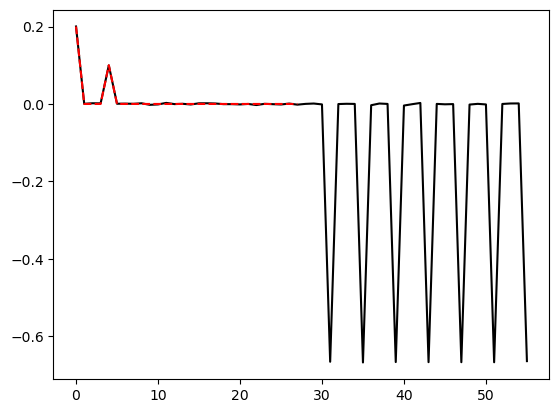

In [10]:
from scipy.sparse.linalg import cg, gmres, LinearOperator, bicgstab
import time

# Build linear operator object
gain_lhs_shape = (xin.size, xin.size)
gain_linear_op = LinearOperator(matvec=gain_lhs_operator,
                                shape=gain_lhs_shape)

# Solve using Conjugate Gradients or similar
t0 = time.time()
x_soln, convergence_info = cg(gain_linear_op, b)
print("Solver took %6.3f sec" % (time.time() - t0))
print("    Gain sampler convergence info:", convergence_info)

# Reshape solution into complex array and multiply by S^1/2 to get set of
# Fourier coeffs of the actual solution for the frac. gain perturbation
#x_soln = hydra.utils.reconstruct_vector(x_soln, 
#                                        gain_shape, 
#                                        reduced_idxs=reduced_idxs)
#x_soln = hydra.gain_sampler.apply_sqrt_pspec(gain_pspec_sqrt, x_soln)
plt.plot(x_soln.flatten(), 'k-')
plt.plot(delta_g_amps.flatten(), 'r--')

In [11]:
x_soln.shape, xin.shape

((56,), (7, 8))

In [12]:


np.seterr(all='raise')


NNN = inv_noise_var_chunk.copy()
NNN *= 0.01
#NNN[1:,:,:] = 0.
print(">>>", NNN.shape)

# Lambda function for LHS matrix-vector product
gain_lhs = lambda v: hydra.gain_sampler.apply_linear_op_mpi(
                                                comm=comm,
                                                ants=ants, 
                                                antpairs=antpairs, 
                                                Fbasis=Fbasis, 
                                                vec=v, 
                                                vec_shape=x_shape,
                                                inv_noise_var=NNN,
                                                gain_pspec_sqrt=gain_pspec_sqrt, 
                                                ggV=ggv_chunk).flatten()

xxre, xxim = np.zeros((Nants, Fbasis.shape[0])), np.zeros((Nants, Fbasis.shape[0]))
xxre[0,2] = 0.04
#xxre[0,2] = 0.01
xxim[0,0] = 0.
xx = np.concatenate((xxre.flatten(), xxim.flatten()))
btest = gain_lhs(xx)

print("xx =", xx)
print("bvec =", btest)


dg_block = np.tensordot(xxre + 1.j*xxim, Fbasis, axes=((1,), (0,)))

"""
plt.subplot(221)
plt.matshow(dg_block.reshape((Nants,-1)).real, aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(222)
plt.matshow(dg_block.reshape((Nants,-1)).imag, aspect='auto', fignum=False)
plt.colorbar()

#print("TTTT", btest)
plt.subplot(223)
plt.matshow((np.abs(btest.reshape((Nants,-1)))), aspect='auto', fignum=False)
#plt.axvline(9.)
plt.colorbar()
plt.show()
"""



# Run normal CG solver
xg = hydra.linear_solver.cg(Amat=None, bvec=btest, linear_op=gain_lhs)
print("Gain solution:", xg)
print("Original x:", xx)

>>> (21, 16, 16)


NameError: name 'comm' is not defined

In [13]:
def apply_linear_op_mpi(ants, antpairs, Fbasis, vec, vec_shape, inv_noise_var, 
                        gain_pspec_sqrt, ggV):
    """
    Apply the linear system operator on each chunk.

    Assume that only the root worker has the correct x vector and distribute 
    it.
    """
    myid = 0

    # FIXME: Need to handle real and imaginary parts properly
    # FIXME: Need to test for correctness

    Nants = len(ants)
    #Nmodes = inv_noise_var.shape[1] * inv_noise_var.shape[2]
    Nmodes = Fbasis.shape[0] # Fbasis: (Ngain_modes, Nfreqs, Ntimes)

    # coeffs of Fbasis should be coeff of real part and coeff of imag part 
    # (*not* real and imag parts of the Fourier coeffs)
    Fb = Fbasis.reshape((Nmodes, -1)).T # (Nblock_freqstimes, Ngain_modes)

    # Broadcast x vector
    x = vec

    # Extract real and imaginary parts, reshape, and multiply by sqrt of prior var
    xre = gain_pspec_sqrt[np.newaxis,:] * x[:x.size//2].reshape((Nants, Nmodes))
    xim = gain_pspec_sqrt[np.newaxis,:] * x[x.size//2:].reshape((Nants, Nmodes))
    #xre = gain_pspec_sqrt[np.newaxis,:] * x[:x.size//2].reshape((Nants, 16,16))
    #xim = gain_pspec_sqrt[np.newaxis,:] * x[x.size//2:].reshape((Nants, 16,16))

    # Calculate delta gain for each antenna (in freq/time space)
    # dg_block ~ (Nants, Nblockfreqs, Nblocktimes)
    dg_block = np.tensordot(xre + 1.j*xim, Fbasis, axes=((1,), (0,)))
    #dg_block = np.array([np.fft.fft2(xre[i] + 1.j*xim[i]) for i in range(Nants)])
    #fft_shape = dg_block.shape
    #Nmodes = 16*16
    
    #dg_block = dg_block.flatten()

    # Maths note: We can expand the (F^T P^T N^-1 P F) operator acting on x, and 
    # turn it into a simple sum over terms for each row of the result vector. 
    # Here, F is the partial Fourier basis operator (from per-antenna coefficients 
    # to per-antenna gains vs freq. and time), and P is the sparse operator that 
    # mixes the gains for each visibility. The inverse noise term is actually the 
    # product with the corresponding visibility times the mean gain, i.e.
    # N^-1 = (g_i g_i^* V_ij)^T (N_ij)^-1 (g_i g_i^* V_ij)^T.

    # If we evaluate this operator acting on x, we get the following expression 
    # for each (block) row:
    # y_i = F^T (Sum_j N^-1_{ij}) (F x_i) \
    #     + F^T (Sum_j N^-1_{ij} (F x_j))
    # where i is the antenna element of this (block) row, for visibility V_ij, 
    # and j is the second antenna in the pair, for all pairs where i is the first 
    # antenna. To simplify, we can write F x_i = (delta g)_i = gg_i, to obtain
    # y_i = F^T (Sum_j N^-1_{ij}) gg_i \
    #     + F^T (Sum_j N^-1_{ij} gg_j)

    # Extract antennas from antpairs
    ant1 = np.array([i for i, j in antpairs])
    ant2 = np.array([j for i, j in antpairs])

    # Initialise result vector for single block (i.e. for gain coeffs for single ant)
    my_y = np.zeros((Nants, 2*Nmodes), dtype=xre.dtype) # y is real

    # Loop over antennas in order
    for k, ant in enumerate(ants):

        # Get idxs of visibilities V_ij that have i=ant or j=ant
        idxs1 = np.where(ant1 == ant)[0]
        idxs2 = np.where(ant2 == ant)[0]

        # Calculate each term in each block element of the result vector
        term1 = np.zeros((Fbasis.shape[1], Fbasis.shape[2]), dtype=np.complex128)
        term1c = np.zeros_like(term1)
        term2 = np.zeros_like(term1)
        term2c = np.zeros_like(term1)

        # Gains where this antena is ant i
        if len(idxs1) > 0:

            # Get idxs of antennas j that have i=ant
            gain_idxs1 = np.array([np.where(ants == aa)[0][0] for aa in ant2[idxs1]])

            # Sum (V^T N^-1 V g) over baselines where i = ant
            # (Should have shape (Nants_in_group, Nfreqs, Ntimes) before sum)
            # All terms with x_ant
            term1 = np.sum(   ggV[idxs1,:,:].conj() \
                            * inv_noise_var[idxs1,:,:] \
                            * ggV[idxs1,:,:] \
                            * dg_block[k][np.newaxis,:,:],
                            axis=0) # x_ant

            # All terms with x_j (where i=ant)
            term2c = np.sum(   ggV[idxs1,:,:].conj() \
                             * inv_noise_var[idxs1,:,:] \
                             * ggV[idxs1,:,:] \
                             * dg_block[gain_idxs1].conj(),
                             axis=0) # x_j^*

        # Gains where this antenna is ant j
        if len(idxs2) > 0:

            # Get idxs of antennas i that have j=ant
            gain_idxs2 = np.array([np.where(ants == aa)[0][0] for aa in ant1[idxs2]])

            # Sum (V^T N^-1 V g) over baselines where j = ant
            # All terms with x_ant^*
            term1c = np.sum(   ggV[idxs2,:,:].conj() \
                             * inv_noise_var[idxs2,:,:] \
                             * ggV[idxs2,:,:] \
                             * dg_block[k][np.newaxis,:,:].conj(),
                             axis=0) # x_ant^*

            # All terms with x_i (where j=ant)
            term2 = np.sum(   ggV[idxs2,:,:].conj() \
                            * inv_noise_var[idxs2,:,:] \
                            * ggV[idxs2,:,:] \
                            * dg_block[gain_idxs2],
                            axis=0) # x_i
        
        """
        plt.subplot(221)
        plt.matshow(term1.real, aspect='auto', fignum=False)
        plt.colorbar()
        
        plt.subplot(222)
        plt.matshow(term1.imag, aspect='auto', fignum=False)
        plt.colorbar()
        
        plt.subplot(223)
        plt.matshow(term1c.real, aspect='auto', fignum=False)
        plt.colorbar()
        
        plt.subplot(224)
        plt.matshow(term1c.imag, aspect='auto', fignum=False)
        plt.colorbar()
        
        plt.show()
        
        
        plt.subplot(221)
        plt.matshow(term2.real, aspect='auto', fignum=False)
        plt.colorbar()
        
        plt.subplot(222)
        plt.matshow(term2.imag, aspect='auto', fignum=False)
        plt.colorbar()
        
        plt.subplot(223)
        plt.matshow(term2c.real, aspect='auto', fignum=False)
        plt.colorbar()
        
        plt.subplot(224)
        plt.matshow(term2c.imag, aspect='auto', fignum=False)
        plt.colorbar()
        
        plt.show()
        
        print("SHAPE", term1.shape)
        """

        # Apply final factor of conjugate transpose F matrix and store as result
        FFc = Fbasis.conj().reshape((Fbasis.shape[0], -1))
        y1 = np.tensordot(FFc, term1.flatten(), axes=((1,), (0,)))
        y1c = np.tensordot(FFc, term1c.flatten(), axes=((1,), (0,)))
        y2 = np.tensordot(FFc, term2.flatten(), axes=((1,), (0,)))
        y2c = np.tensordot(FFc, term2c.flatten(), axes=((1,), (0,)))
        #y1 = np.fft.ifft2(term1)
        #y1c = np.fft.ifft2(term1c)
        #y2 = np.fft.ifft2(term2)
        #y2c = np.fft.ifft2(term2c)
        
        """
        plt.subplot(221)
        plt.matshow(y1.real, aspect='auto', fignum=False)
        plt.colorbar()
        
        plt.subplot(222)
        plt.matshow(y1.imag, aspect='auto', fignum=False)
        plt.colorbar()
        
        plt.subplot(223)
        plt.matshow(y1c.real, aspect='auto', fignum=False)
        plt.colorbar()
        
        plt.subplot(224)
        plt.matshow(y1c.imag, aspect='auto', fignum=False)
        plt.colorbar()
        
        plt.show()
        
        
        plt.subplot(221)
        plt.matshow(y2.real, aspect='auto', fignum=False)
        plt.colorbar()
        
        plt.subplot(222)
        plt.matshow(y2.imag, aspect='auto', fignum=False)
        plt.colorbar()
        
        plt.subplot(223)
        plt.matshow(y2c.real, aspect='auto', fignum=False)
        plt.colorbar()
        
        plt.subplot(224)
        plt.matshow(y2c.imag, aspect='auto', fignum=False)
        plt.colorbar()
        
        plt.show()
        
        raise
        """
        my_y[k,:Nmodes] = (gain_pspec_sqrt * (y1 + y1c + y2 + y2c).real).flatten()

        # FIXME: This is just guessing!
        my_y[k,Nmodes:] = (gain_pspec_sqrt * (y1 + y1c + y2 + y2c).imag).flatten()
        
    return x + my_y.flatten() # add identity times input too


In [14]:
       
# Shape of the gain solution vector
x_shape = 2*len(ants)*Fbasis.shape[0]


xxre, xxim = np.zeros((Nants, Fbasis.shape[0])), np.zeros((Nants, Fbasis.shape[0]))



xxre[:,:] = 0.1 * np.random.randn(*xxre.shape)
xxim[:,:] = 0.1 * np.random.randn(*xxre.shape)
xx = np.concatenate((xxre.flatten(), xxim.flatten()))
xxin = xx.copy()

bb = apply_linear_op_mpi(ants, antpairs, Fbasis, xx, x_shape, inv_noise_var_chunk, 
                         gain_pspec_sqrt, ggv_chunk)


"""
for val in np.linspace(-1., 1., 7):
    xxre[0,2] = val
    xxim[0,2] = 0.8
    xx = np.concatenate((xxre.flatten(), xxim.flatten()))

    lhs = apply_linear_op_mpi(ants, antpairs, Fbasis, xx, x_shape, inv_noise_var_chunk, 
                            gain_pspec_sqrt, ggv_chunk)
    plt.plot(np.abs(lhs.real - bb.real), label="val = %5.3f" % val)

#plt.xlim((0., 5.))
plt.yscale('log')
plt.legend()
"""
print()

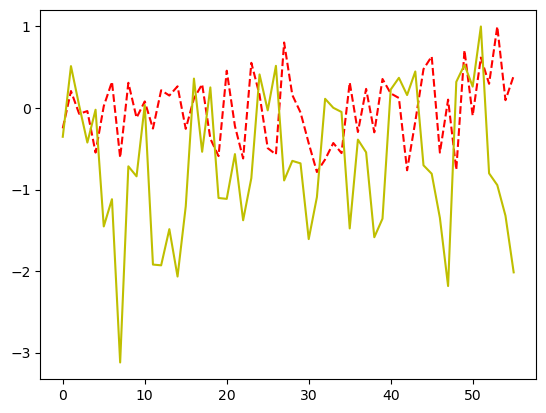

In [15]:
plt.plot(xx / xx.max(), 'r--')
plt.plot(bb / bb.max(), 'y-')

In [16]:
from scipy.sparse.linalg import cg, gmres, LinearOperator, bicgstab

In [17]:
lhs_fn = lambda v: apply_linear_op_mpi(ants, antpairs, Fbasis, v, x_shape, inv_noise_var_chunk, 
                                       gain_pspec_sqrt, ggv_chunk)

linop = LinearOperator(matvec=lhs_fn, shape=(xx.size, xx.size))

In [18]:
import scipy
print("scipy:", scipy.__version__)
print("numpy:", np.__version__)

scipy: 1.7.3
numpy: 1.20.3


In [19]:
xsoln, status = cg(linop, bb)

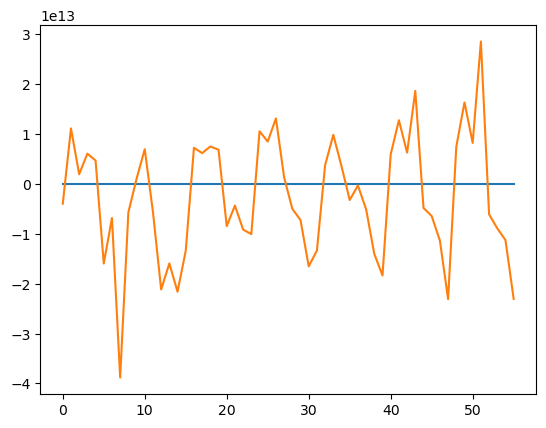

In [20]:
#plt.plot(np.abs(xxin) - np.abs(xsoln))
plt.plot(xxin)
plt.plot(xsoln)
#plt.plot()
#plt.yscale('log')

In [21]:
Lfreq = (freqs[1] - freqs[0]) * freqs.size
Ltime = (times[1] - times[0]) * times.size
Fbasis, k_freq, k_time = hydra.utils.partial_fourier_basis_2d_from_nmax(
                                            freqs=freqs, 
                                            times=times, 
                                            nmaxfreq=8, 
                                            nmaxtime=8, 
                                            Lfreq=Lfreq, 
                                            Ltime=Ltime)

In [22]:
FFc = Fbasis.conj().reshape((Fbasis.shape[0], -1))
ymode = np.tensordot(FFc, y.flatten(), axes=((1,), (0,))).reshape((16, 16))

NameError: name 'y' is not defined

NameError: name 'ymode' is not defined

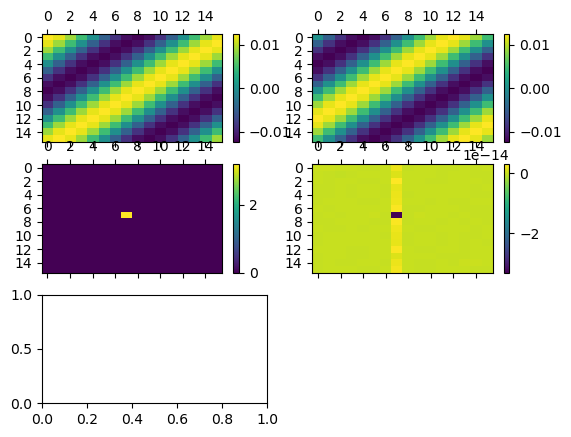

In [23]:
y = delta_g_chunk[0].copy()

plt.subplot(321)
plt.matshow(y.real, aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(322)
plt.matshow(y.imag, aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(323)
plt.matshow(np.fft.fftshift(np.fft.fft2(y).real), aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(324)
plt.matshow(np.fft.fftshift(np.fft.fft2(y).imag), aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(325)
plt.matshow(ymode.real, aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(326)
plt.matshow(ymode.imag, aspect='auto', fignum=False)
plt.colorbar()

plt.gcf().set_size_inches((14., 14.))

In [ ]:
ymode.shape

In [ ]:
289//16

In [ ]:
print(np.unique(k_freq) / (2.*np.pi))
print(np.fft.fftshift(np.fft.fftfreq(16, d=freqs[1]-freqs[0])))

In [ ]:
import sympy as sp

In [24]:
antpairs = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]

# Gain values (real)
a0 = sp.Symbol('a0')
a1 = sp.Symbol('a1')
a2 = sp.Symbol('a2')
a3 = sp.Symbol('a3')

# Gain values (imag)
b0 = sp.Symbol('b0')
b1 = sp.Symbol('b1')
b2 = sp.Symbol('b2')
b3 = sp.Symbol('b3')

# Visibilities (real)
u01 = sp.Symbol('u_01')
u02 = sp.Symbol('u_02')
u03 = sp.Symbol('u_03')
u12 = sp.Symbol('u_12')
u13 = sp.Symbol('u_13')
u23 = sp.Symbol('u_23')

# Visibilities (imag)
v01 = sp.Symbol('v_01')
v02 = sp.Symbol('v_02')
v03 = sp.Symbol('v_03')
v12 = sp.Symbol('v_12')
v13 = sp.Symbol('v_13')
v23 = sp.Symbol('v_23')

xvec = sp.Matrix([a0, a1, a2, a3, b0, b1, b2, b3])

vis = sp.Matrix([u01, u02, u03, u12, u13, u23,
                 v01, v02, v03, v12, v13, v23])

Xre, Xim = []
for i,j in antpairs:
    rowr, rowi = [], []
    for k in range(4):
        if i == k:
            rowr.append(1)
            rowi.append(-1)
        elif j == k:
            rowr.append(1)
            rowi.append(-1j)
        else:
            rowr.append(0)
            rowi.append(0)
    Xre.append(rowr + rowi)
Xre = sp.Matrix(Xre)

sp.pprint(Xre)



N01 = sp.Symbol('N_01')
N02 = sp.Symbol('N_02')
N03 = sp.Symbol('N_03')
N12 = sp.Symbol('N_12')
N13 = sp.Symbol('N_13')
N23 = sp.Symbol('N_23')
Ninv = sp.diag(*[N01, N02, N03, N12, N13, N23])
#sp.pprint(Ninv)
sp.pprint(xvec)
sp.pprint(vis)

NameError: name 'sp' is not defined

In [25]:
sp.conjugate(proj.T) @ Ninv @ proj @ xvec

NameError: name 'sp' is not defined

In [26]:
sp.conjugate(proj.T) @ Ninv @ proj

NameError: name 'sp' is not defined

In [27]:
freqs = np.linspace(100., 120., 32)
times = np.linspace(0., 1., 24)

# Get chunk of Fourier operator
Lfreq = (freqs[1] - freqs[0]) * freqs.size
Ltime = (times[1] - times[0]) * times.size
Fbasis0, k_freq0, k_time0 = hydra.utils.partial_fourier_basis_2d_from_nmax(
                                            freqs=freqs, 
                                            times=times, 
                                            nmaxfreq=2, 
                                            nmaxtime=2, 
                                            Lfreq=Lfreq, 
                                            Ltime=Ltime,
                                            freq0=freqs[0],
                                            time0=times[0])

(32, 24) (16, 768) (16, 32, 24)


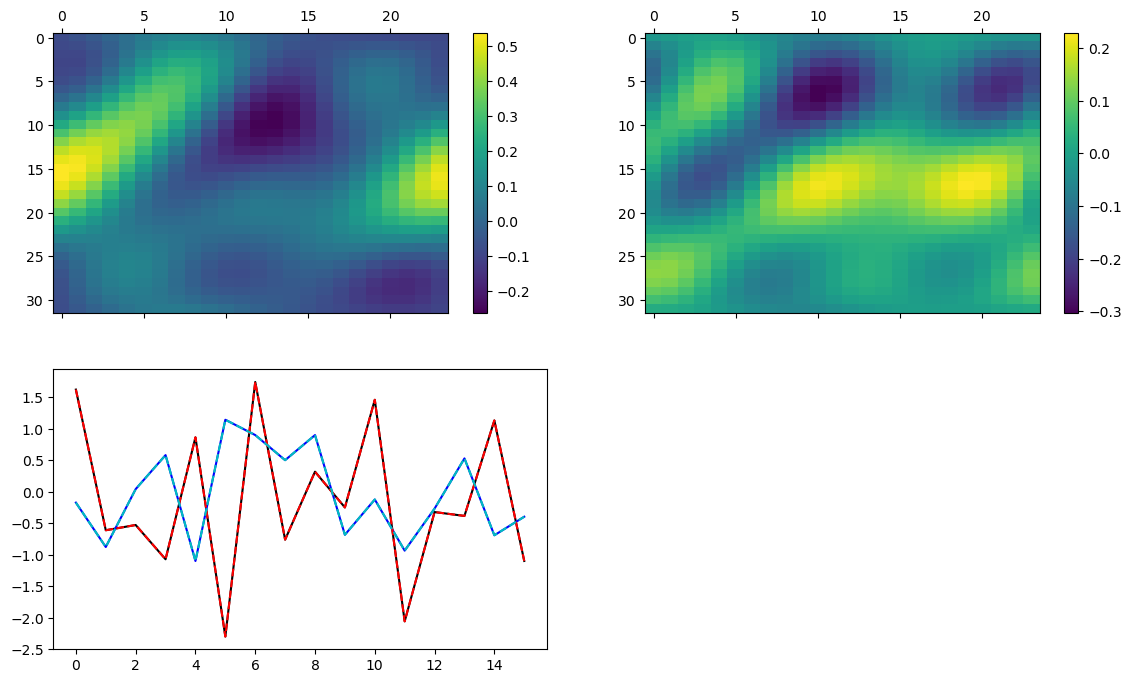

In [28]:
# Generate Fourier data
np.random.seed(1)
x = np.random.randn(Fbasis0.shape[0]) + 1.j*np.random.randn(Fbasis0.shape[0])
FFc0 = Fbasis0.conj().reshape((Fbasis0.shape[0], -1))

# Do FT to go into Fourier space again
#y = np.tensordot(FFc, yy[k, :, :].flatten(), axes=((1,), (0,)))
y = np.tensordot(Fbasis0, x, axes=((0,), (0,)))

print(y.shape, FFc0.shape, Fbasis0.shape)

xfft = np.tensordot(FFc0, y.flatten(), axes=((1,), (0,)))



plt.subplot(221)
plt.matshow(y.real, aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(222)
plt.matshow(y.imag, aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(223)
plt.plot(x.real, 'k-')
plt.plot(x.imag, 'b-')

plt.plot(xfft.real, 'r--')
plt.plot(xfft.imag, 'c--')

plt.gcf().set_size_inches((14., 8.))

(8, 6)
(16, 8, 6)
(8, 6)
(16, 8, 6)
(8, 6)
(16, 8, 6)
(8, 6)
(16, 8, 6)
(8, 6)
(16, 8, 6)
(8, 6)
(16, 8, 6)
(8, 6)
(16, 8, 6)
(8, 6)
(16, 8, 6)
(8, 6)
(16, 8, 6)
(8, 6)
(16, 8, 6)
(8, 6)
(16, 8, 6)
(8, 6)
(16, 8, 6)
(8, 6)
(16, 8, 6)
(8, 6)
(16, 8, 6)
(8, 6)
(16, 8, 6)
(8, 6)
(16, 8, 6)


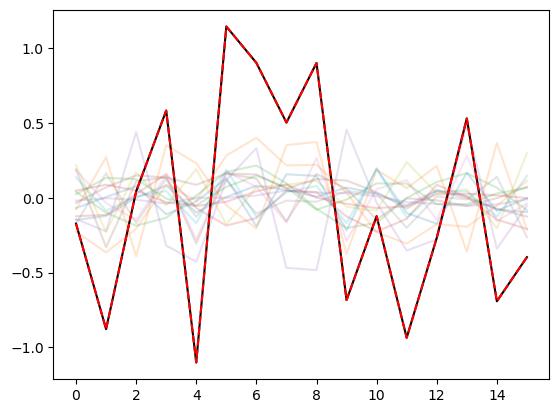

In [29]:


fchunks = tchunks = 4
xtot = 0

for i in range(fchunks * tchunks):
    # Get chunk of freqs/times for this worker
    freq_idxs, time_idxs = hydra.utils.freqs_times_for_worker(i, freqs=freqs, times=times, 
                                                      fchunks=fchunks, tchunks=tchunks)
    freq_chunk = freqs[freq_idxs]
    time_chunk = times[time_idxs]
    
    # Get chunk of Fourier operator
    Lfreq = (freqs[1] - freqs[0]) * freqs.size
    Ltime = (times[1] - times[0]) * times.size
    FbasisC, k_freq, k_time = hydra.utils.partial_fourier_basis_2d_from_nmax(
                                                freqs=freq_chunk, 
                                                times=time_chunk, 
                                                nmaxfreq=2, 
                                                nmaxtime=2, 
                                                Lfreq=Lfreq, 
                                                Ltime=Ltime,
                                                freq0=freqs[0],
                                                time0=times[0],
                                                shape0=(freqs.size, times.size))
    
    my_y = y[freq_idxs][:,time_idxs]
    print(my_y.shape)
    
    FFcC = FbasisC.conj().reshape((FbasisC.shape[0], -1))
    print(FbasisC.shape)
    
    xchunk = np.tensordot(FFcC, my_y.flatten(), axes=((1,), (0,)))
    plt.plot(xchunk.imag, alpha=0.2)
    xtot += xchunk

plt.plot(x.imag, 'k-')
plt.plot(xtot.imag, 'r--')
    